### Lesson Outline

In this lesson you will :

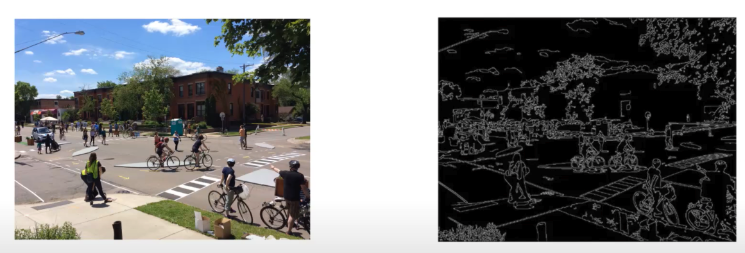

* Create filters to identify the edges of objects within images based on changes in color intensity.

* Create filters to remove "noise" within object images for more precise object detection

* Implement edge detection for objects in images using multiple methods including Hough line detection and Haar cascades.

* Review resources on mitigating algorithmic bias within object detection models.

  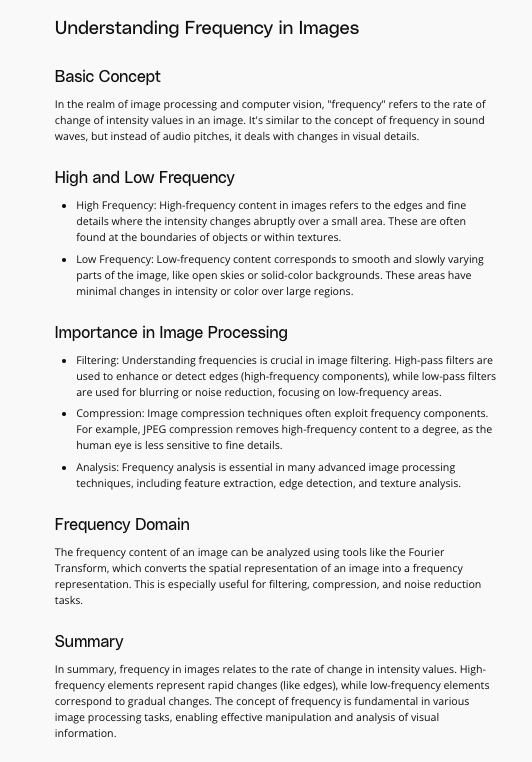


## Fourier Transforms

The frequency components of an image can be displayed after doing a Fourier Transform (FT). An FT looks at the components of an image (edges that are high-frequency, and areas of smooth color as low-frequency), and plots the frequencies that occur as points in spectrum.

In fact, an FT treats patterns of intensity in an image as sine waves with a particular frequency, and you can look at an interesting visualization of these sine wave components [on this page](https://plus.maths.org/content/fourier-transforms-images).

In this notebook, we'll first look at a few simple image patterns to build up an idea of what image frequency components look like, and then transform a more complex image to see what it looks like in the frequency domain.

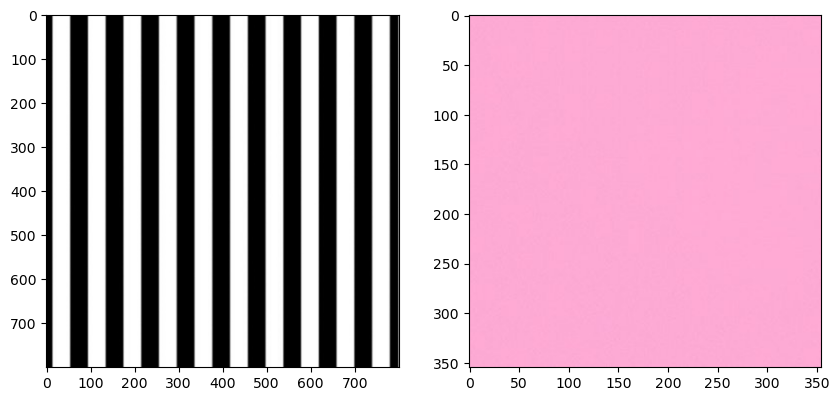

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

# Read in the images
image_stripes = cv2.imread('images/stripes.jpg')
# Change color to RGB (from BGR)
image_stripes = cv2.cvtColor(image_stripes, cv2.COLOR_BGR2RGB)

# Read in the images
image_solid = cv2.imread('images/pink_solid.jpg')
# Change color to RGB (from BGR)
image_solid = cv2.cvtColor(image_solid, cv2.COLOR_BGR2RGB)


# Display the images
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.imshow(image_stripes)
ax2.imshow(image_solid)

In [3]:
# convert to grayscale to focus on the intensity patterns in the image
gray_stripes = cv2.cvtColor(image_stripes, cv2.COLOR_RGB2GRAY)
gray_solid = cv2.cvtColor(image_solid, cv2.COLOR_RGB2GRAY)

# normalize the image color values from a range of [0,255] to [0,1] for further processing
norm_stripes = gray_stripes/255.0
norm_solid = gray_solid/255.0

# perform a fast fourier transform and create a scaled, frequency transform image
def ft_image(norm_image):
    '''This function takes in a normalized, grayscale image
       and returns a frequency spectrum transform of that image. '''
    f = np.fft.fft2(norm_image)
    fshift = np.fft.fftshift(f)
    frequency_tx = 20*np.log(np.abs(fshift))
    
    return frequency_tx

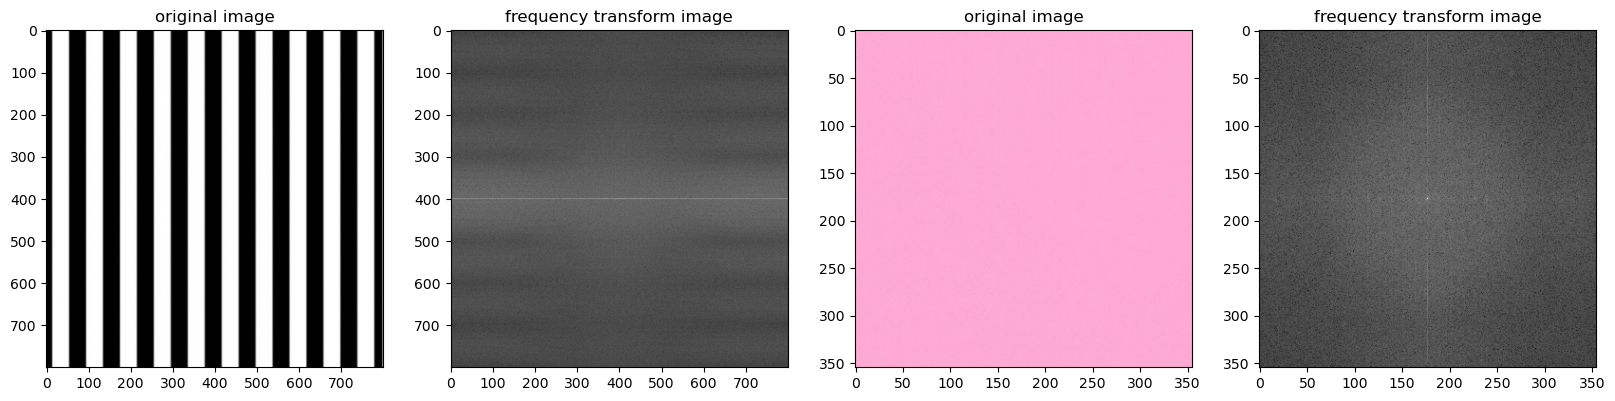

In [4]:
# Call the function on the normalized images
# and display the transforms
f_stripes = ft_image(norm_stripes)
f_solid = ft_image(norm_solid)

# display the images
# original images to the left of their frequency transform
f, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(20,10))

ax1.set_title('original image')
ax1.imshow(image_stripes)
ax2.set_title('frequency transform image')
ax2.imshow(f_stripes, cmap='gray')

ax3.set_title('original image')
ax3.imshow(image_solid)
ax4.set_title('frequency transform image')
ax4.imshow(f_solid, cmap='gray')


Low frequencies are at the center of the frequency transform image. 

The transform images for these example show that the solid image has most low-frequency components (as seen by the center bright spot). 

The stripes tranform image contains low-frequencies for the areas of white and black color and high frequencies for the edges in between those colors. The stripes transform image also tells us that there is one dominating direction for these frequencies; vertical stripes are represented by a horizontal line passing through the center of the frequency transform image.

Next, let's see what this looks like applied to a real-world image.

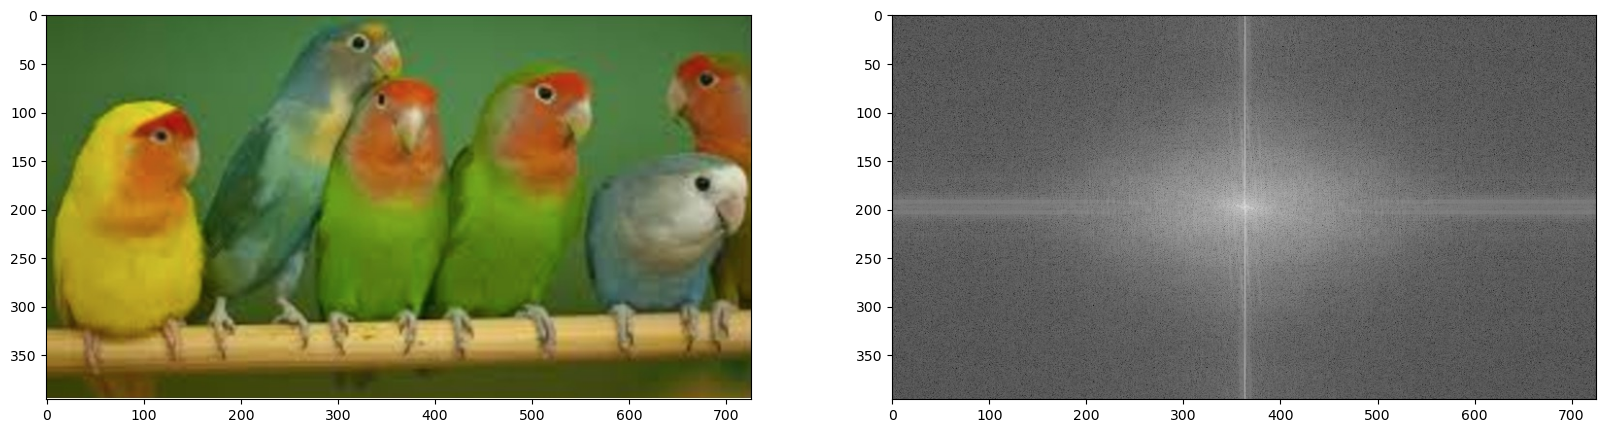

In [5]:
# Read in an image
image = cv2.imread('images/birds.jpg')
# Change color to RGB (from BGR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# normalize the image
norm_image = gray/255.0

f_image = ft_image(norm_image)

# Display the images
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.imshow(image)
ax2.imshow(f_image, cmap='gray')

Notice that this image has components of all frequencies. You can see a bright spot in the center of the transform image, which tells us that a large portion of the image is low-frequency; this makes sense since the body of the birds and background are solid colors. The transform image also tells us that there are **two** dominating directions for these frequencies; vertical edges (from the edges of birds) are represented by a horizontal line passing through the center of the frequency transform image, and horizontal edges (from the branch and tops of the birds' heads) are represented by a vertical line passing through the center.

__Edge Handling__
Kernel convolution relies on centering a pixel and looking at its surrounding neighbors. So, what do you do if there are no surrounding pixels like on an image corner or edge? Well, there are a number of ways to process the edges, which are listed below. It’s most common to use padding, cropping, or extension. In extension, the border pixels of an image are copied and extended far enough to result in a filtered image of the same size as the original image.

__Extend__ The nearest border pixels are conceptually extended as far as necessary to provide values for the convolution. Corner pixels are extended in 90° wedges. Other edge pixels are extended in lines.

__Padding__ The image is padded with a border of 0's, black pixels.

__Crop__ Any pixel in the output image which would require values from beyond the edge is skipped. This method can result in the output image being slightly smaller, with the edges having been cropped.

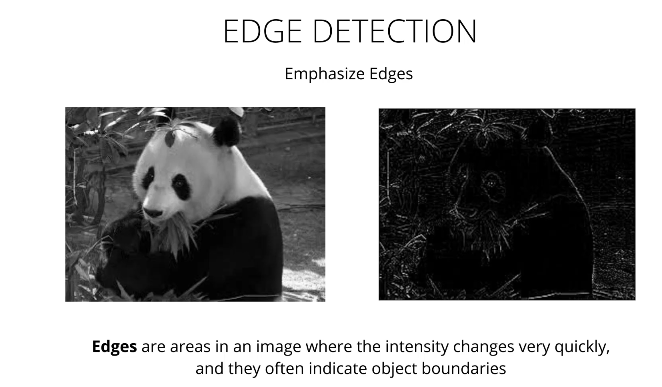 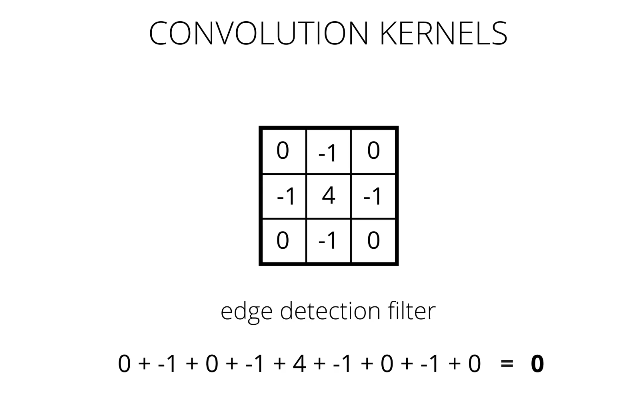 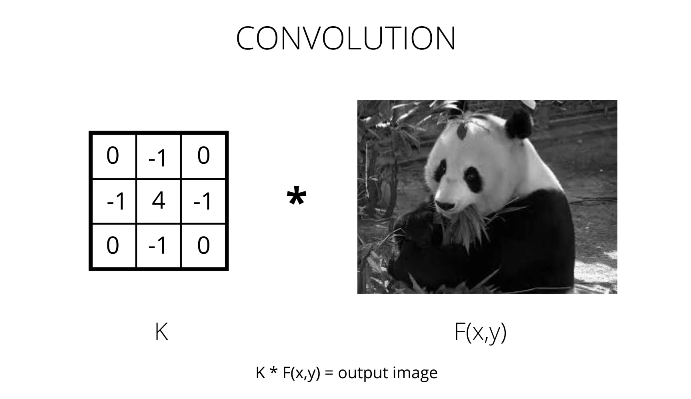 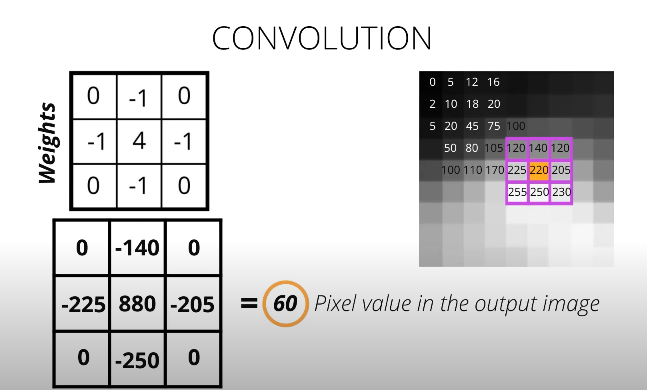

## Creating a Filter


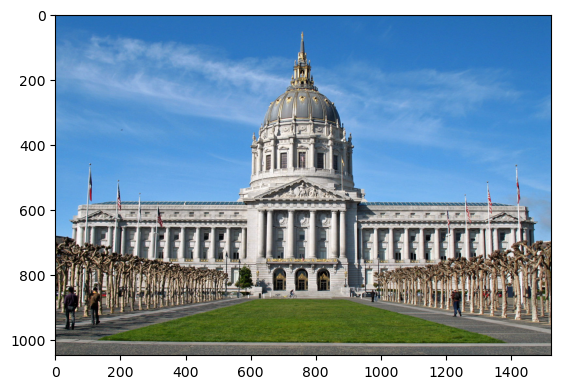

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

# Read in the image
image = cv2.imread("images/city_hall.jpg")

#Make copy of the image
image_copy = np.copy(image)

#Change the color to RGB from BGR
image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)
plt.imshow(image_copy)

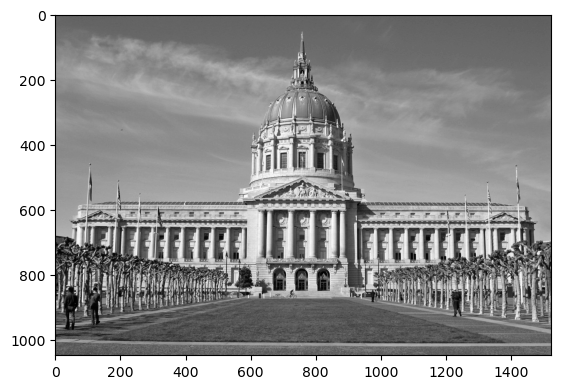

In [9]:
# Convert image to grayscale 

gray = cv2.cvtColor(image_copy, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray')

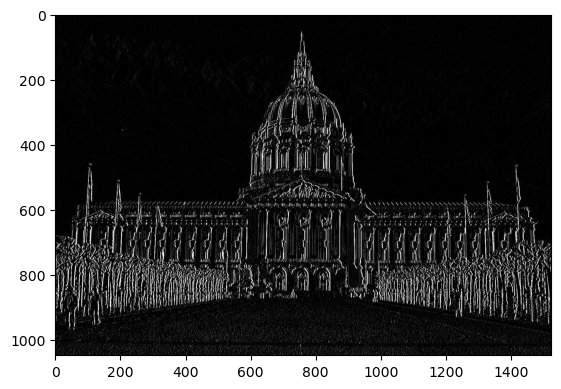

In [12]:
# Create a custom filter

# 3*3 array for edge detection
# Sober filter : it creates the kernel to detect edges which are vertical 

sobel_x = np.array([[-1, 0, 1],
                  [-2, 0, 2],
                  [-1, 0, 1]])


# Perform convolution using filter2D, which has inputs: (grayscale_image, bit-depth, kernel)
filtered_image = cv2.filter2D(gray, -1, sobel_x) # -1 means output will have the same type as the input image
plt.imshow(filtered_image, cmap='gray')

100.0


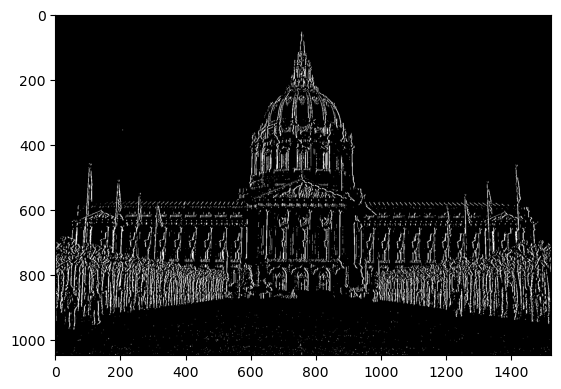

In [17]:
#Create binary Image

# Create threshold that sets all the filtered pixels to white  above a certain threshold

retval, binary_image = cv2.threshold(filtered_image, 100, 255, cv2.THRESH_BINARY)
plt.imshow(binary_image, cmap='gray')


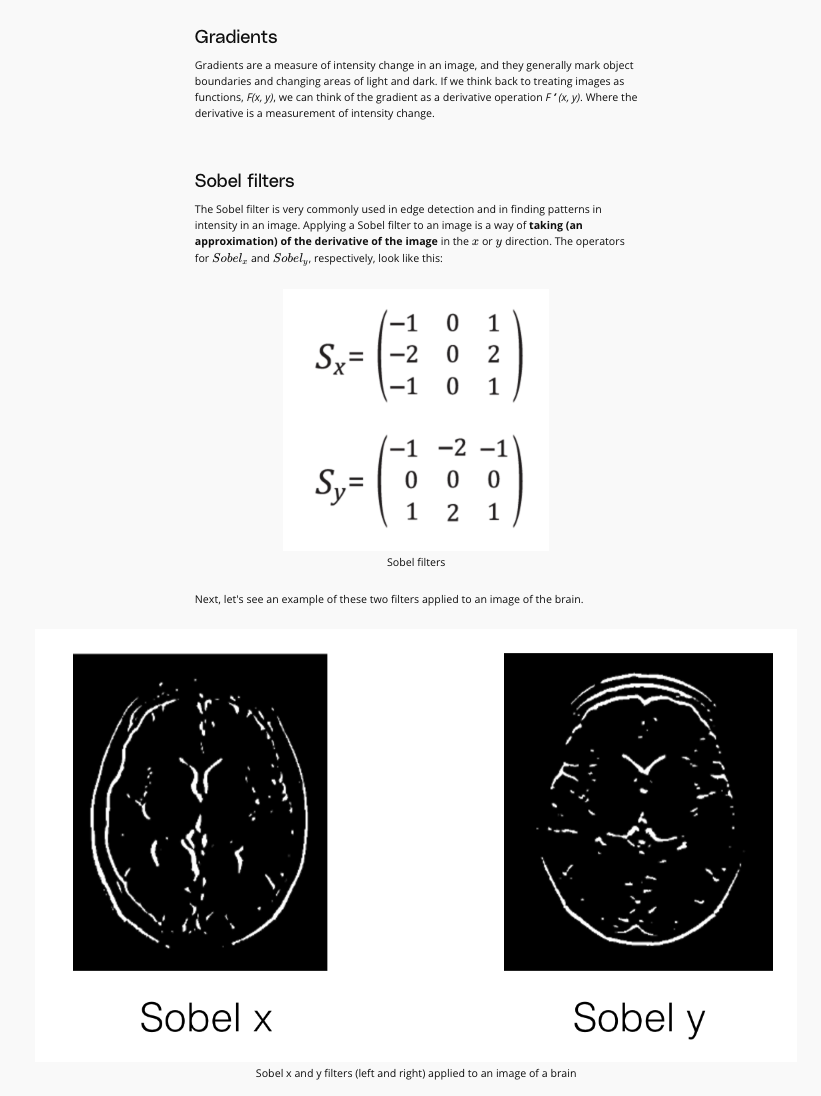 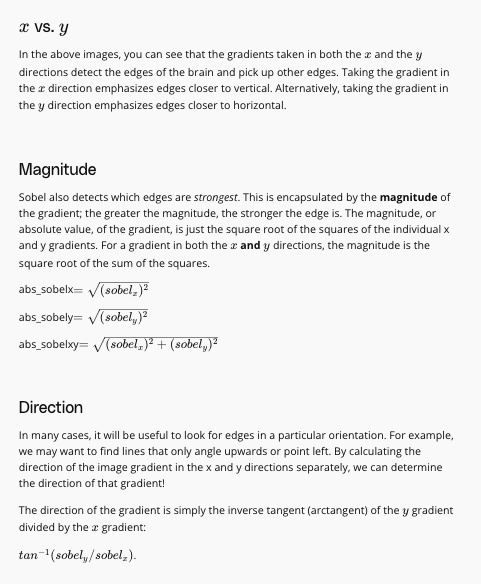

## Finding Edges

### Creating a Filter, Edge Detection

In [18]:
# Import resources and display image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2
import numpy as np

%matplotlib inline

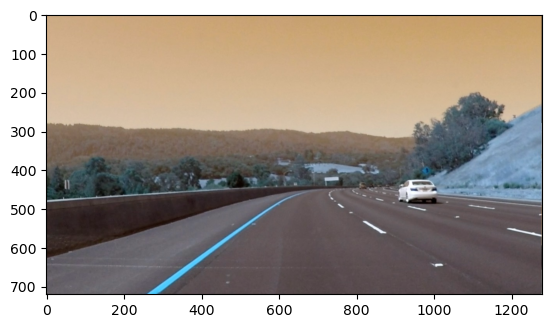

In [19]:
# Read in the image and conver to grayscale
image = cv2.imread("images/curved_lane.jpg")
plt.imshow(image)

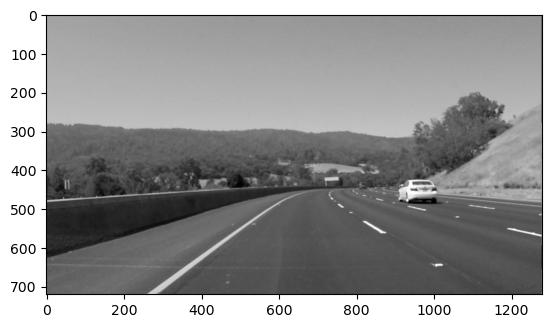

In [20]:
image_copy = np.copy(image)

#convert to grayscale
gray = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

### TODO: Create a custom kernel

Below, you've been given one common type of edge detection filter: a Sobel operator.

The Sobel filter is very commonly used in edge detection and in finding patterns in intensity in an image. Applying a Sobel filter to an image is a way of **taking (an approximation) of the derivative of the image** in the x or y direction, separately. The operators look as follows.

<img src="images/sobel_ops.png" width=200 height=200>

**It's up to you to create a Sobel x operator and apply it to the given image.**

For a challenge, see if you can put the image through a series of filters: first one that blurs the image (takes an average of pixels), and then one that detects the edges.

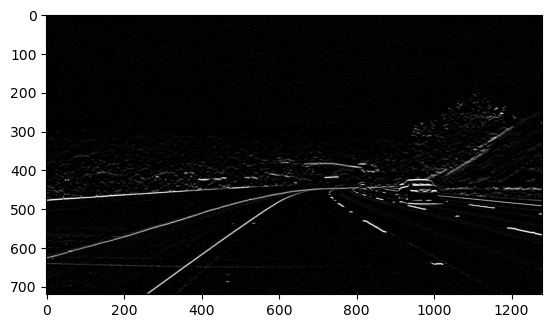

In [24]:
# Create a custom kernel

# 3x3 array for edge detection
sobel_y = np.array([[ -1, -2, -1], 
                   [ 0, 0, 0], 
                   [ 1, 2, 1]])

## TODO: Create and apply a Sobel x operator
sobel_x = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])


# Filter the image using filter2D, which has inputs: (grayscale image, bit-depth, kernel)  
filtered_image = cv2.filter2D(gray, -1, sobel_y)

plt.imshow(filtered_image, cmap='gray')




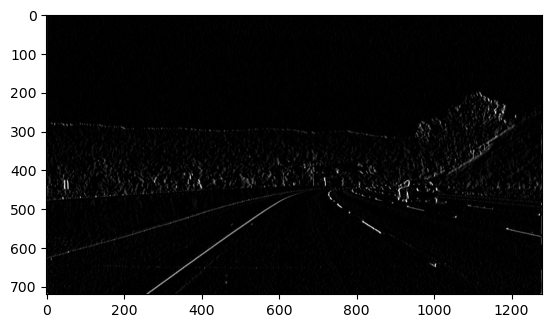

In [27]:

filtered_image2 = cv2.filter2D(gray, -1, sobel_x)
plt.imshow(filtered_image2, cmap='gray')

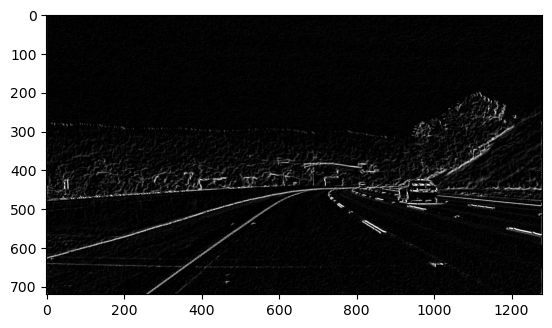

In [29]:
final = filtered_image2 + filtered_image # I exerimented to mix both of them
plt.imshow(final, cmap='gray')

# LOW PASS FILTERS 

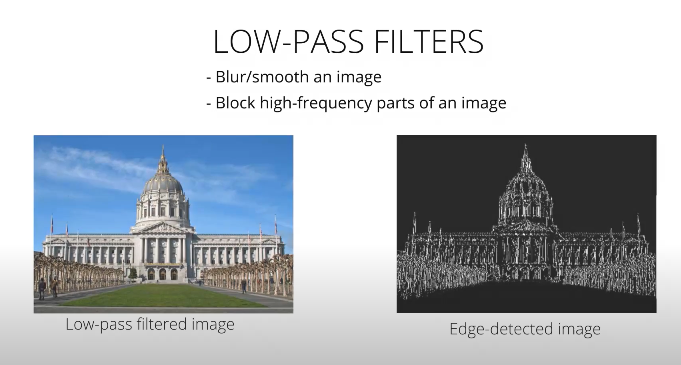 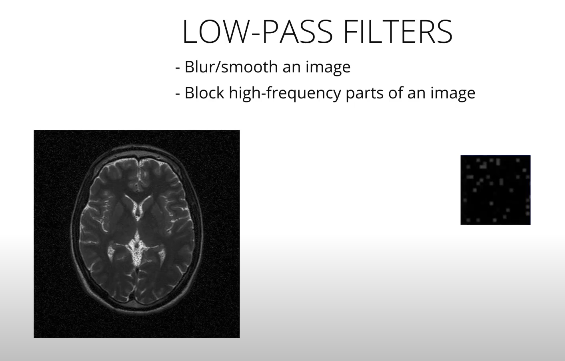 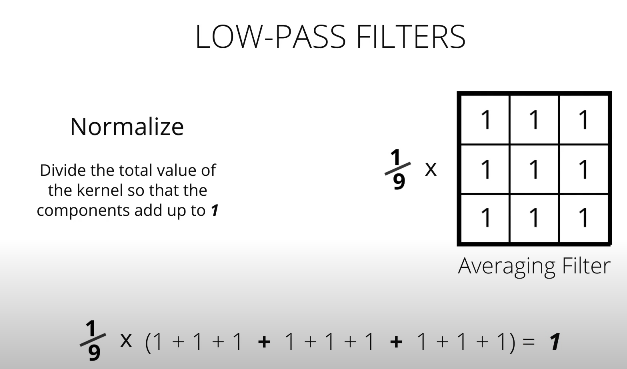 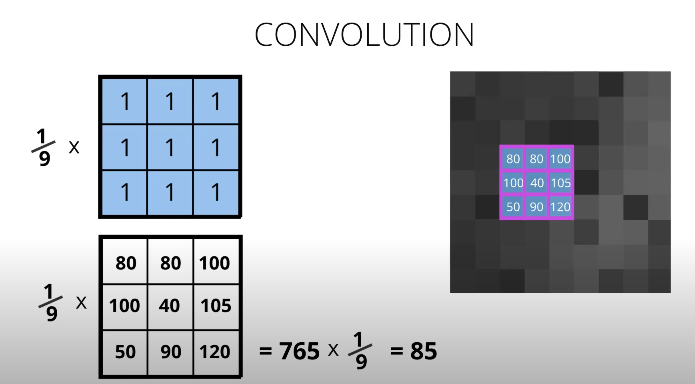

the same happens in the photoshop also to clean the photos and make them to look better

## Gaussian Blur
`we may want to filter that both blurs and image and better preserves the edges in it, then we use the gaussian blurrr`

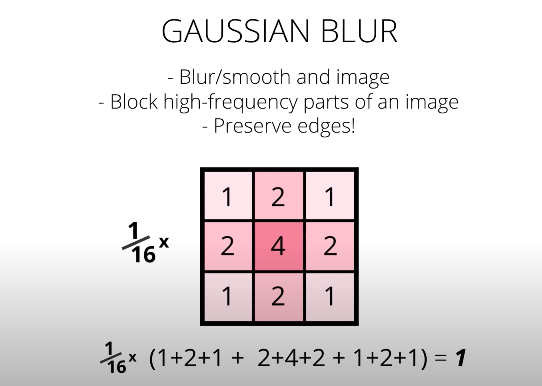

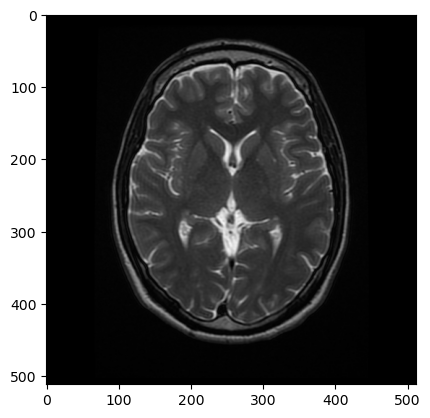

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

image = cv2.imread('images/brain_MR.jpg')
image_copy = np.copy(image)

image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)

plt.imshow(image_copy)

## Gaussian Blur the image 


Text(0.5, 1.0, 'Gaussian Blurred Image')

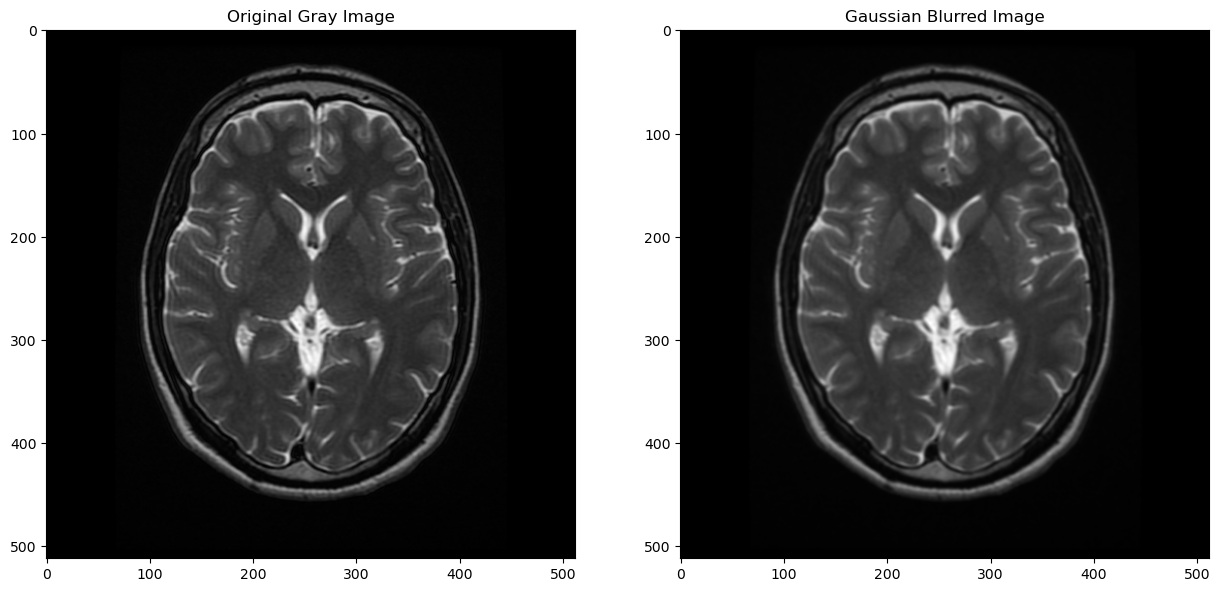

In [39]:
# Convert to grayscale for filtering 
gray = cv2.cvtColor(image_copy, cv2.COLOR_RGB2GRAY)

# Create a Gaussian blurred image
gray_blurr = cv2.GaussianBlur(gray, (5,5), 0) 

f, ax = plt.subplots(1, 2, figsize = (15, 10))

ax[0].imshow(gray, cmap='gray')
ax[0].set_title("Original Gray Image")

ax[1].imshow(gray_blurr, cmap='gray')
ax[1].set_title("Gaussian Blurred Image")

### Test performance with a high-pass filter

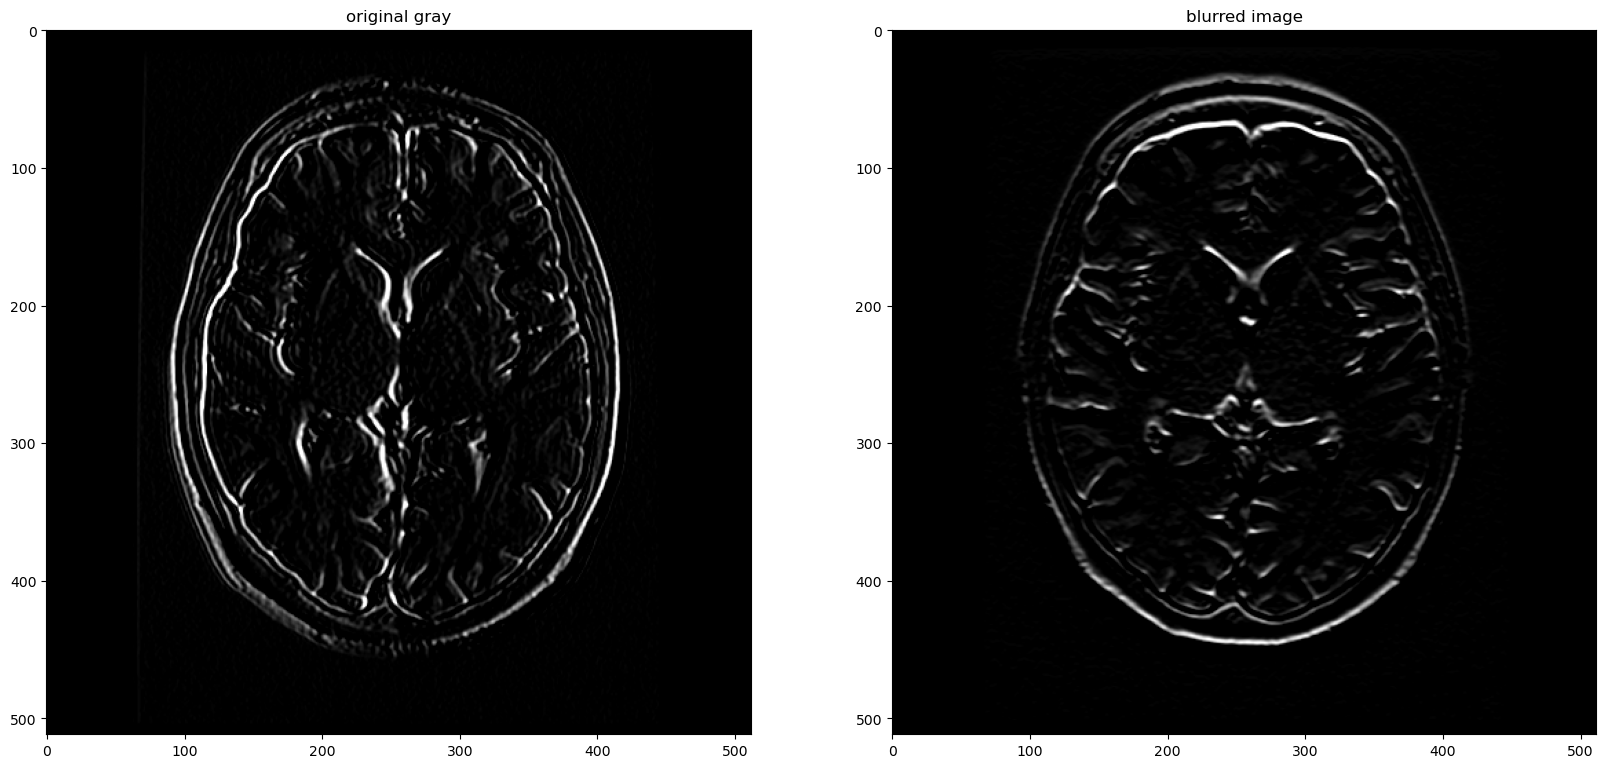

In [41]:
# High-pass filter 

# 3x3 sobel filters for edge detection
sobel_x = np.array([[ -1, 0, 1], 
                   [ -2, 0, 2], 
                   [ -1, 0, 1]])


sobel_y = np.array([[ -1, -2, -1], 
                   [ 0, 0, 0], 
                   [ 1, 2, 1]])

# Filter the orginal and blurred grayscale images using filter2D
filtered = cv2.filter2D(gray, -1, sobel_x)

filtered_blurred = cv2.filter2D(gray_blurr, -1, sobel_y)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.set_title('original gray')
ax1.imshow(filtered, cmap='gray')

ax2.set_title('blurred image')
ax2.imshow(filtered_blurred, cmap='gray')

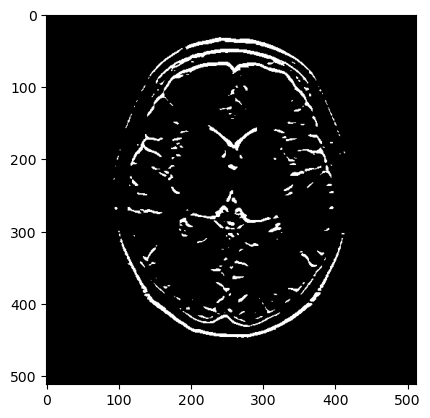

In [46]:
# Create threshold that sets all the filtered pixels to white
# Above a certain threshold

retval, binary_image = cv2.threshold(filtered_blurred, 50, 255, cv2.THRESH_BINARY)

plt.imshow(binary_image, cmap='gray')


# Fourier Transforms of Filters

## High and Low Pass Filters

Now, you might be wondering, what makes filters high and low-pass; why is a Sobel filter high-pass and a Gaussian filter low-pass?

Well, you can actually visualize the frequencies that these filters block out by taking a look at their fourier transforms. The frequency components of any image can be displayed after doing a Fourier Transform (FT). An FT looks at the components of an image (edges that are high-frequency, and areas of smooth color as low-frequency), and plots the frequencies that occur as points in spectrum. So, let's treat our filters as small images, and display them in the frequency domain!

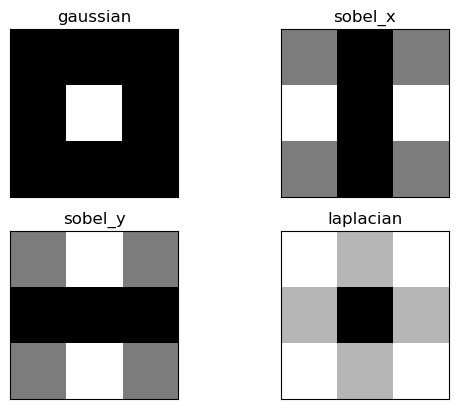

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

# Define gaussian, sobel, and laplacian (edge) filters

gaussian = (1/9)*np.array([[1, 1, 1],
                           [1, 1, 1],
                           [1, 1, 1]])

sobel_x= np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])

sobel_y= np.array([[-1,-2,-1],
                   [0, 0, 0],
                   [1, 2, 1]])

# laplacian, edge filter
laplacian=np.array([[0, 1, 0],
                    [1,-4, 1],
                    [0, 1, 0]])



filters = [gaussian, sobel_x, sobel_y, laplacian]
filter_name = ['gaussian','sobel_x', \
                'sobel_y', 'laplacian']


# perform a fast fourier transform on each filter
# and create a scaled, frequency transform image
f_filters = [np.fft.fft2(x) for x in filters]
fshift = [np.fft.fftshift(y) for y in f_filters]
frequency_tx = [np.log(np.abs(z)+1) for z in fshift]

# display 4 filters
for i in range(len(filters)):
    plt.subplot(2,2,i+1),plt.imshow(frequency_tx[i],cmap = 'gray')
    plt.title(filter_name[i]), plt.xticks([]), plt.yticks([])

plt.show()

Areas of white or light gray, allow that part of the frequency spectrum through! Areas of black mean that part of the spectrum is blocked out of the image. 

Recall that the low frequencies in the frequency spectrum are at the center of the frequency transform image, and high frequencies are at the edges. You should see that the Gaussian filter allows only low-pass frequencies through, which is the center of the frequency transformed image. The sobel filters block out frequencies of a certain orientation and a laplace (all edge, regardless of orientation) filter, should block out low-frequencies!

You are encouraged to load in an image, apply a filter to it using `filter2d` then visualize what the fourier transform of that image looks like before and after a filter is applied.

#### Images found in workspace include:
* image/brain_MR.jpg
* image/city_hall.jpg
* image/city_hall_zoom.png
* image/curved_lane.jpg

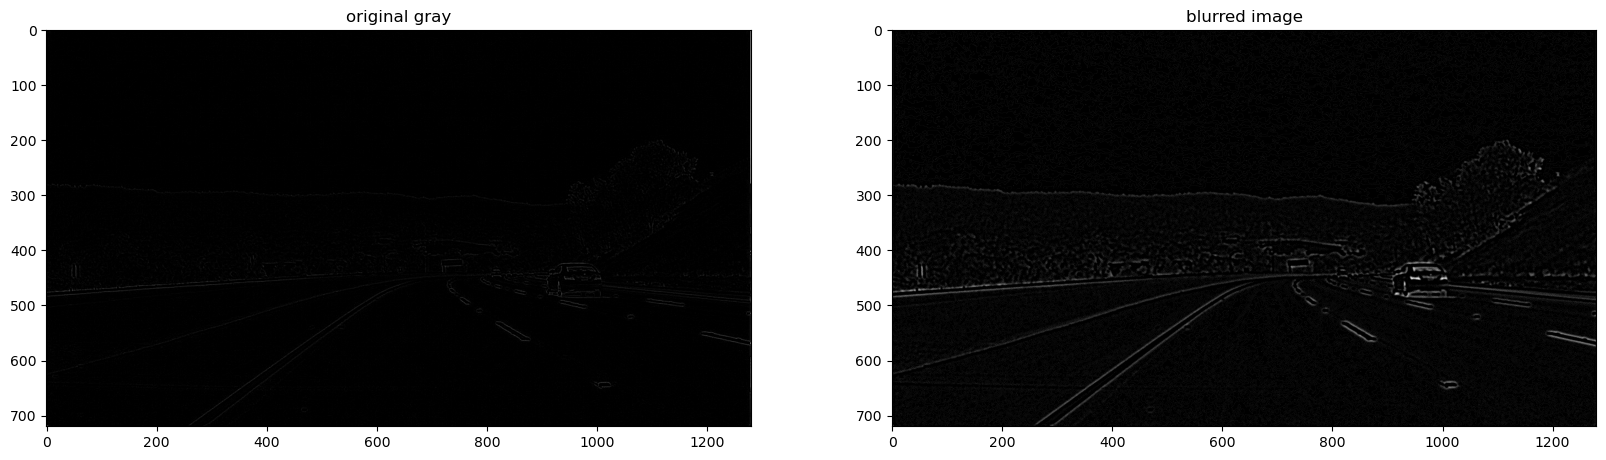

In [48]:
## Possible Solution Using laplacian, edge filter
#### Read in the image
image = cv2.imread('images/curved_lane.jpg')

#### Make a copy of the image
image_copy = np.copy(image)

#### Change color to RGB (from BGR)
image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)

#### Convert to grayscale for filtering
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

#### Filter the image using filter2D, which has inputs: (grayscale image, bit-depth, kernel)  
filtered_image = cv2.filter2D(gray, -1, laplacian)

#### Create a Gaussian blurred image
gray_blur = cv2.GaussianBlur(gray, (9, 9), 0)

#### Filter the orginal and blurred grayscale images using filter2D
filtered_image = cv2.filter2D(gray, -1, laplacian)

filtered_blurred = cv2.filter2D(gray_blur, -1, laplacian)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.set_title('original gray')
ax1.imshow(filtered_image, cmap='gray')

ax2.set_title('blurred image')
ax2.imshow(filtered_blurred, cmap='gray')
